In [2]:
import pickle
import numpy as np
import cv2
import scipy.stats
import copy
import os

In [39]:
filename = '/home/riffelluser/artificial_images/fly_ellipses_and_colors.pickle'
f = open(filename)
data = pickle.load(f)
f.close()

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import find_flies_in_image_directory
from multi_tracker_analysis import read_hdf5_file_to_pandas as mta_read

1.5.1
recommended version: 1.1.1 or greater
Using open cv: 3.2.0-dev
Open CV 3


1


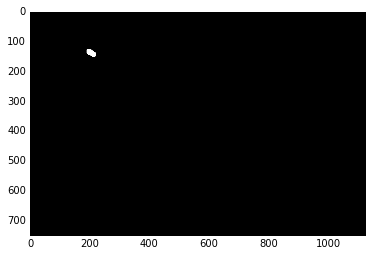

In [421]:
directory = '/home/riffelluser/align_test'
median = find_flies_in_image_directory.create_median_gray_small_image_from_directory(directory)


file_list = mta_read.get_filenames(directory, '.jpg')

file = os.path.join(directory, 'green5.jpg')

resize_factor=0.2
threshold=40
pixels_per_mm=10
min_fly_length_mm=1
max_fly_ecc=5

full_img = cv2.imread(file, cv2.CV_8UC1)
image = cv2.resize(full_img, (0,0), fx=resize_factor, fy=resize_factor) 

absdiff = cv2.absdiff(image, median)
retval, threshed = cv2.threshold(absdiff, threshold, 255, 0)

kern_d = 3
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kern_d,kern_d))
threshed = cv2.morphologyEx(threshed,cv2.MORPH_OPEN, kernel, iterations = 1)

kernel = np.ones((3,3), np.uint8)
threshed = cv2.dilate(threshed, kernel, iterations=5)
threshed = cv2.erode(threshed, kernel, iterations=2)

# http://docs.opencv.org/trunk/doc/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html
threshed = np.uint8(threshed)
image, contours, hierarchy = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(threshed, cmap='gray')

print len(contours)

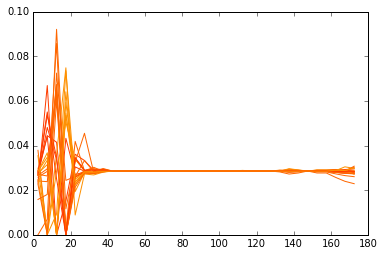

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)

all_hues = []
for f, flies in data.items():
    for fly in flies:
        ax.plot(fly['hue_bins'], fly['hue_relative'], color=np.array(fly['rgb_color_peak'])/256.)

In [48]:
10/255.

0.0392156862745098

In [224]:
import fly_align
reload(fly_align)

<module 'fly_align' from 'fly_align.py'>

fly_align.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  zoom = copy.copy(img[_l:_r, _b:_t, :])


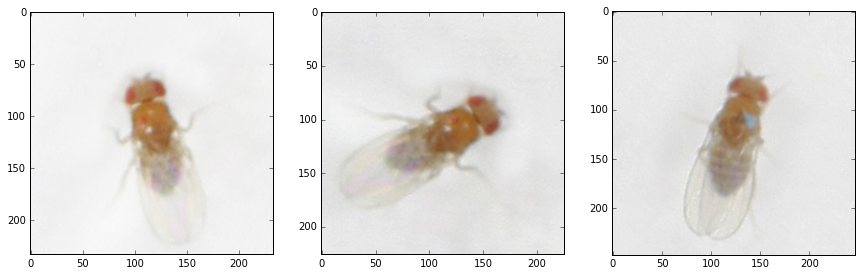

In [6]:
fly_rois, fly_info = fly_align.load_all_fly_rois('/home/riffelluser/align_test')

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(141)
ax.imshow(fly_rois.values()[0])

ax = fig.add_subplot(142)
ax.imshow(fly_rois.values()[1])

ax = fig.add_subplot(143)
ax.imshow(fly_rois.values()[2])

In [225]:
rotated_rois = []
rotated_rois_P = []
rotated_rois_N = []

reference_fly = fly_info.values()[0]

luminance = []
for fly in fly_info.values():
    luminance.append(fly['luminance'])
mean_luminance = np.mean(luminance)

for fly_id in fly_rois.keys():
    roi = fly_rois[fly_id]
    ellipse = fly_info[fly_id]['ellipse']
    
    # rotations introduce black pixels, which could throw off alignment.
    # let's make a mask so that anything outside of the largest inscribed circle is black
    
    rows,cols,channels = roi.shape
    
    # equalize exposure
    img_hsv = cv2.cvtColor(roi,cv2.COLOR_RGB2HSV)
    v_shift = fly_info[fly_id]['luminance'] - mean_luminance
    v = img_hsv[:,:,2].astype(float) - v_shift
    np.clip(v, 0, 255, out=v)
    v = v.astype('uint8')
    img_hsv[:,:,2] = v
    roi = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    
        
    if np.mean(scipy.stats.mode(roi)) > 125:
        roi = 255-roi
    roi -= np.min(roi)
    #print np.min(roi), np.min(roi-np.min(roi))
    
    
    if len(rotated_rois) > 0:
        aligned_p = fly_align.align_two_flies(rotated_rois[0], roi, ellipse[2])
        err_p = np.sum(np.abs(aligned_p.astype(float) - np.mean(rotated_rois, axis=0).astype(float)))
        aligned_n = fly_align.align_two_flies(rotated_rois[0], roi, ellipse[2]+180)
        err_n = np.sum(np.abs(aligned_n.astype(float) - np.mean(rotated_rois, axis=0).astype(float)))
        if err_p < err_n:
            aligned = aligned_p
        else:
            aligned = aligned_n
        print err_p, err_n
        
    else:
        M = cv2.getRotationMatrix2D((cols/2,rows/2),ellipse[2],1)
        roi_rotated = cv2.warpAffine(roi,M,(cols,rows))
        aligned = roi_rotated
    
    
    rotated_rois.append( aligned )

[[  4.66387630e-01  -3.29661191e-01   4.95950508e+01]
 [ -9.33954418e-02   2.20433936e-01   3.59177856e+01]
 [ -7.54270295e-04  -3.02728033e-03   1.00000000e+00]]
[[  9.59152341e-01   4.21928242e-02  -5.00630426e+00]
 [ -5.25029376e-02   1.00259268e+00   3.64755940e+00]
 [ -2.51556630e-04   1.29190405e-04   1.00000000e+00]]
1561642.0 1223131.0
[[  3.51752579e-01  -4.77092147e-01   7.92737427e+01]
 [  6.34235237e-03   1.71057284e-01   2.94994431e+01]
 [ -1.05846231e-03  -3.23480647e-03   1.00000000e+00]]
[[  1.17826390e+00   5.39334528e-02   1.99217749e+00]
 [  1.52853251e-01   1.52671576e+00  -4.27885056e+01]
 [ -3.10596632e-04   1.79806002e-03   1.00000000e+00]]
1307389.5 1054009.5
[[  4.93522108e-01  -5.44298053e-01   7.67676468e+01]
 [  1.67077594e-02   9.91156474e-02   3.68720856e+01]
 [ -2.58949498e-04  -3.88902519e-03   1.00000000e+00]]
[[  1.51812625e+00   3.24843943e-01  -2.36370049e+01]
 [  9.37959105e-02   1.94879615e+00  -2.86306801e+01]
 [  1.25933657e-04   2.72453157e-03  

15 4


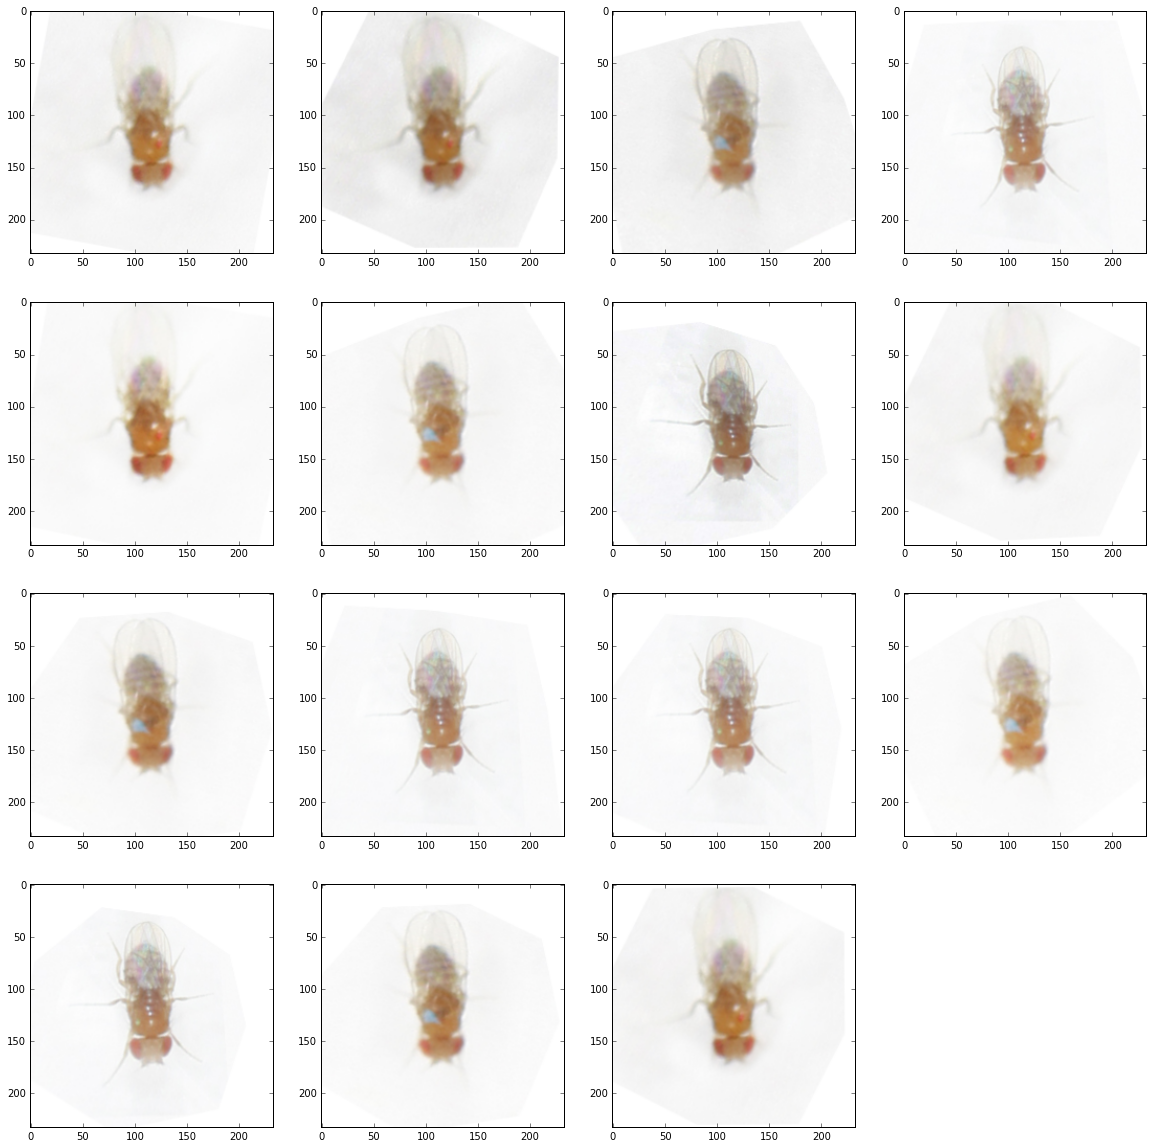

In [226]:
rotated_rois_inv = [255-r for r in rotated_rois]

fig = plt.figure(figsize=(20,20))

n = len(rotated_rois_inv)
nsqrt = int(np.sqrt(n))+1

print n, nsqrt

for i in range(n):
    ax = fig.add_subplot(nsqrt, nsqrt, i+1)
    ax.imshow(rotated_rois_inv[i])



In [227]:
aligned_hsv = [cv2.cvtColor(r,cv2.COLOR_RGB2HSV) for r in rotated_rois_inv]

2361


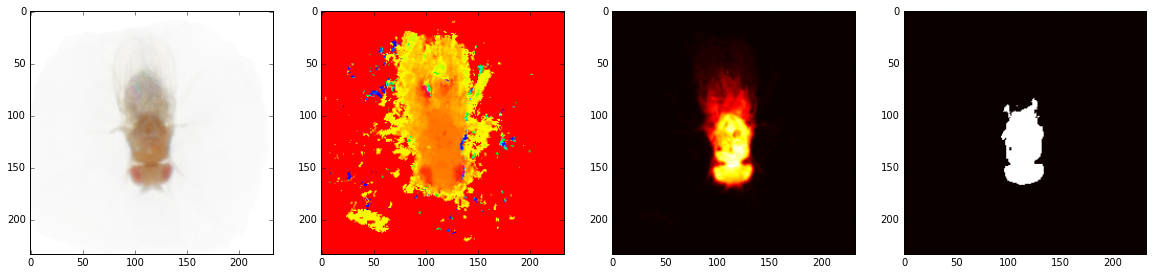

In [228]:
fig = plt.figure(figsize=(20,20))

#ax.imshow(np.mean(all_flies[2:4], axis=0))

hsv_mean = np.median(aligned_hsv, axis=0).astype(np.uint8)
hsv_std = np.std(aligned_hsv, axis=0).astype(np.uint8)
rgb_mean = cv2.cvtColor(hsv_mean,cv2.COLOR_HSV2RGB)

ax = fig.add_subplot(141)
ax.imshow( rgb_mean )

ax = fig.add_subplot(142)
ax.imshow( hsv_mean[:,:,0], cmap='hsv' )

ax = fig.add_subplot(143)
ax.imshow( hsv_mean[:,:,1], cmap='hot' )

mask = hsv_mean[:,:,1]>60
mask3 = np.dstack((mask, mask, mask))
print np.sum(mask)

ax = fig.add_subplot(144)
ax.imshow( mask, cmap='hot' )




In [235]:
min_error = 0.1


fly_models = {}

for i, roi in enumerate(rotated_rois):
    print len(fly_models)
    if len(fly_models) == 0:
        fly_models[0] = [roi]
        
    else:
        errors = []
        models = []
        alignments = []
        for m, model in fly_models.items():
            model_mean = np.mean(model, axis=0).astype(np.uint8)
            aligned = fly_align.align_two_flies( model_mean, roi, 0)
            #aligned = roi
            
            fly_1_hsv = cv2.cvtColor(model_mean,cv2.COLOR_RGB2HSV)
            fly_2_hsv = cv2.cvtColor(aligned,cv2.COLOR_RGB2HSV)

            g1 = np.mean(fly_1_hsv[:,:,0]*mask)
            g2 = np.mean(fly_2_hsv[:,:,0]*mask)

            print g1, g2
            diff_1 = (fly_1_hsv.astype(float)-g1 - hsv_mean.astype(float))[:,:,0]*mask
            diff_2 = (fly_2_hsv.astype(float)-g2 - hsv_mean.astype(float))[:,:,0]*mask
            
            #err_hsv = np.sum( np.abs( aligned_hsv - model_mean_hsv )[:,:,0]*mask )/float(np.sum(mask)*180)
            #err_sat = np.sum( np.abs( aligned_hsv - model_mean_hsv )[:,:,1]*mask )/float(np.sum(mask)*255)
            
            err = np.mean( np.abs((diff_1) - (diff_2) ) )
            errors.append(err)
            models.append(m)
            aligned = roi
            alignments.append(aligned)
        print errors
        if np.min(errors) < min_error:
            idx = np.argmin(errors)
            model_number = models[idx]
            aligned = alignments[idx]
            fly_models[model_number].append(aligned)
        else:
            new_model_number = np.max(fly_models.keys())+1
            fly_models[new_model_number] = [roi]

for m, model in fly_models.items():
    print m, len(model)

0
1
[[  1.10651124e+00   5.76773565e-03  -5.92261696e+00]
 [  5.26615418e-02   1.05481517e+00  -5.36407614e+00]
 [  4.66131489e-04   4.57146161e-05   1.00000000e+00]]
4.54285398515 4.5320414817
[0.020109519244914519]
1
[[  9.43720937e-01  -8.90131071e-02   9.44439602e+00]
 [  4.08437811e-02   8.24977219e-01   7.49366093e+00]
 [  1.56749040e-04  -7.14557362e-04   1.00000000e+00]]
4.53812006115 4.42135607582
[0.22263253933130103]
2
[[  9.56282318e-01  -8.61407258e-03   4.42637348e+00]
 [  1.57709687e-03   9.51912105e-01   4.73284817e+00]
 [ -1.04666600e-04  -2.14700922e-05   1.00000000e+00]]
4.53812006115 4.45919062794
[[  9.89444375e-01   7.15302825e-02  -2.25587010e+00]
 [ -5.38669154e-02   1.11149526e+00  -6.27899408e-01]
 [ -3.11120413e-04   6.53356023e-04   1.00000000e+00]]
4.41791154746 4.46237727716
[0.12355388640377891, 0.28733279033812914]
3
[[  1.01435614e+00   7.95406741e-05  -2.10699420e-02]
 [  1.87533889e-02   1.00769210e+00  -1.24277902e+00]
 [  1.11966387e-04   9.73192437

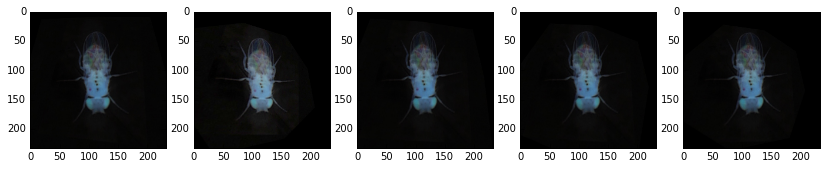

In [236]:
fig = plt.figure(figsize=(20,20))
m = 2
for i, model in enumerate(fly_models[m]):
    ax = fig.add_subplot(1,7,i+1)
    ax.imshow(fly_models[m][i])

[[  1.08101296e+00  -1.75442234e-01   1.14830666e+01]
 [  3.16131294e-01   7.61336088e-01  -8.10948086e+00]
 [  1.16728537e-03  -1.19711272e-03   1.00000000e+00]]
4.27069940504 4.25846856638
0.0694476616076


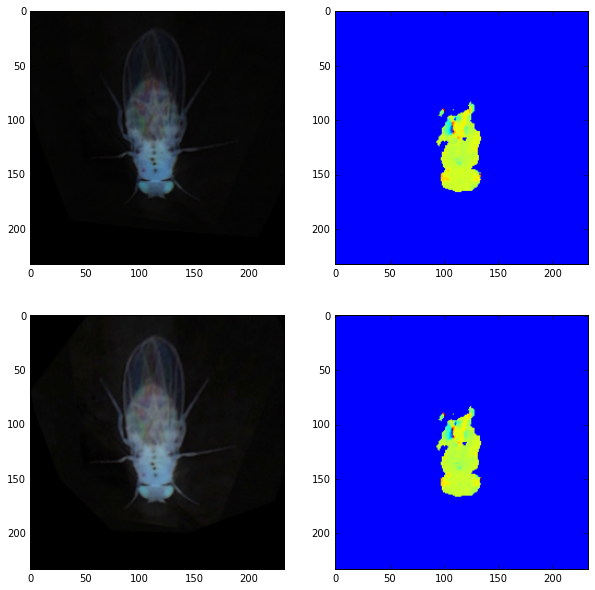

In [211]:

fly_1 = rotated_rois[3]

fly_2 = fly_align.align_two_flies( fly_1, rotated_rois[6], 0)

fly_1_hsv = cv2.cvtColor(fly_1,cv2.COLOR_RGB2HSV)
fly_2_hsv = cv2.cvtColor(fly_2,cv2.COLOR_RGB2HSV)

g1 = np.mean(fly_1_hsv[:,:,0]*mask)
g2 = np.mean(fly_2_hsv[:,:,0]*mask)

print g1, g2
diff_1 = (fly_1_hsv.astype(float)-g1 - hsv_mean.astype(float))[:,:,0]*mask
diff_2 = (fly_2_hsv.astype(float)-g2 - hsv_mean.astype(float))[:,:,0]*mask

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.imshow(fly_1)
ax = fig.add_subplot(2,2,2)
ax.imshow(diff_1)
ax = fig.add_subplot(2,2,3)
ax.imshow(fly_2)
ax = fig.add_subplot(2,2,4)
ax.imshow(diff_2)

err_d_1 = np.mean(diff_1)
err_d_2 = np.mean(diff_2)
print np.mean( np.abs((diff_1) - (diff_2) ) )

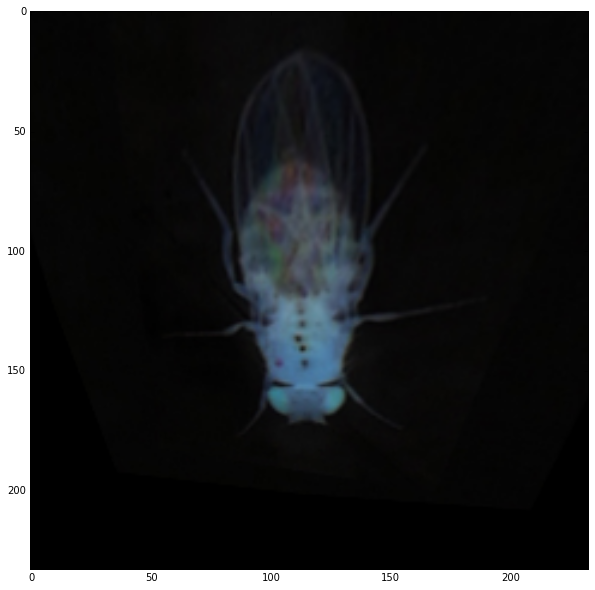

In [94]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(rotated_rois[4])

In [237]:
import pickle


In [244]:
f = open('/home/riffelluser/demo/demo_1/data/20170828_154907_N1_gphoto2/fly_rois/fly_data.pickle')
fly_data = pickle.load(f)
f.close()

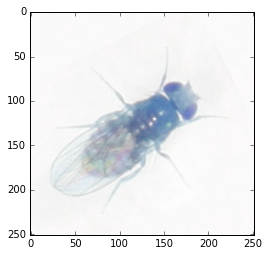

In [308]:
idx = 10
img = cv2.imread(fly_data[idx]['roi_filename'])
ellipse = fly_data[idx]['ellipse']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(img)

In [382]:
mask_ellipse = af.get_elliptical_fly_mask(new_roi, ellipse, ellipse_value=0)
masked = new_roi*(1-mask_ellipse)

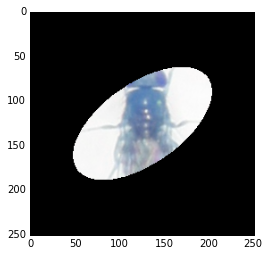

In [383]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(masked)

In [379]:
print np.mean(masked[:,125:,:])
print np.mean(masked[:,0:125,:])

40.2761133942
39.1374448871


In [395]:
import indi_tracker_analysis.fly_align_v2 as af
reload(af)

<module 'indi_tracker_analysis.fly_align_v2' from '/home/riffelluser/Documents/virtualenvs/PYQ/local/lib/python2.7/site-packages/indi_tracker_analysis/fly_align_v2.pyc'>

In [365]:
new_roi = af.rotate_roi(img, ellipse)

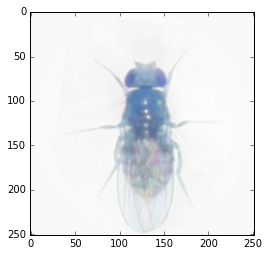

In [366]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow( new_roi )

In [384]:
print np.mean(new_roi[125:,:,2])
print np.mean(new_roi[0:125,:,2])

237.73478836
241.403015873


In [385]:
print np.mean(new_roi[:,125:,2])
print np.mean(new_roi[:,0:125,2])

238.370737522
240.771505976


In [389]:
sat_mask = af.get_saturation_mask(new_roi)

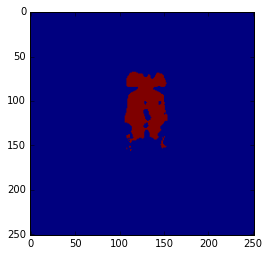

In [390]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow( sat_mask )

In [394]:
print np.sum(sat_mask[:,125:])
print np.sum(sat_mask[:,0:125])

1552
1110


In [393]:
print np.sum(sat_mask[125:,:])
print np.sum(sat_mask[0:125,:])

573
2089


In [408]:
reload(af)
mean_fly = af.get_median_roi('/home/riffelluser/demo/demo_1/data/20170828_172331_N1_gphoto2/fly_rois')

[[  1.00000000e+00  -6.72901601e-09   3.36283597e-06]
 [  6.54984789e-10   1.00000000e+00   1.70356543e-06]
 [ -8.78022308e-12  -6.29922711e-11   1.00000000e+00]]
[[  9.71525908e-01   8.10141489e-03   2.26069117e+00]
 [ -4.55100276e-02   9.48441803e-01   1.35212860e+01]
 [ -8.17474502e-05  -3.36169091e-04   1.00000000e+00]]
[[  9.65954006e-01  -1.99993774e-02   1.00964108e+01]
 [  1.17070913e-01   1.08051455e+00  -1.31248713e+01]
 [ -1.14481569e-04   5.13529521e-04   1.00000000e+00]]
[[  1.06226611e+00  -2.00485270e-02   4.58440259e-02]
 [  7.80028617e-03   1.05475485e+00  -2.03449225e+00]
 [ -2.46800500e-05  -4.32559391e-05   1.00000000e+00]]
[[  9.09832954e-01   4.08927530e-01  -1.21707840e+01]
 [ -1.76662043e-01   1.39543033e+00   1.88735943e+01]
 [ -9.76781477e-04   2.88739544e-03   1.00000000e+00]]
[[  6.74483716e-01   6.83276951e-02   1.50081325e+00]
 [ -3.79560292e-02   7.86310315e-01   1.05587749e+01]
 [ -8.54139565e-04   4.27375984e-04   1.00000000e+00]]
[[  1.06222689e+00   1

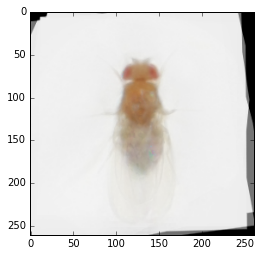

In [409]:
mean_fly_rgb = cv2.cvtColor(mean_fly, cv2.COLOR_HSV2RGB)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow( mean_fly_rgb )

In [400]:
mean_fly.shape

(261, 262, 3)